In [7]:
import xarray as xr
import dask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os, sys, glob, re, time, math, calendar

# import custom functions
sys.path.append('/')
from libraries import *
from plotters import *

In [8]:
station_id = 'PROF_OWEG'

profiler_ds = xr.open_dataset(f'data/NYSM_standard_and_profiler_combined_wind_speed/{station_id}.nc')
profiler_data = profiler_ds.wind_speed.sel(range=slice(10,500),time=slice('2018-01-01T00',f'2020-12-31T23'))
profiler_z = profiler_ds.range.values

filtered_profiler_data = profiler_data.where(profiler_data.notnull().all(dim='range'), drop=True)
filtered_profiler_data

<xarray.DataArray 'wind_speed' (range: 18, time: 15164)> Size: 1MB
array([[ 3.5617554,  4.526838 ,  4.987547 , ...,  4.391111 ,  5.366741 ,
         3.1872804],
       [ 8.531982 ,  9.550075 , 11.010124 , ...,  9.055127 ,  7.931102 ,
         6.8374777],
       [ 9.215181 , 10.099037 , 11.522149 , ...,  9.228447 ,  8.354878 ,
         7.6853004],
       ...,
       [14.876497 , 14.761024 , 17.368385 , ..., 15.971254 , 10.317045 ,
        14.677211 ],
       [15.36315  , 14.560764 , 17.591682 , ..., 16.195717 , 10.066393 ,
        14.035677 ],
       [15.547368 , 14.981998 , 17.96914  , ..., 14.556767 , 10.123579 ,
        13.581298 ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 121kB 2018-01-04T17:00:00 ... 2020-12-31T0...
  * range    (range) int64 144B 10 100 125 150 175 200 ... 400 425 450 475 500
    station  <U9 36B 'PROF_OWEG'

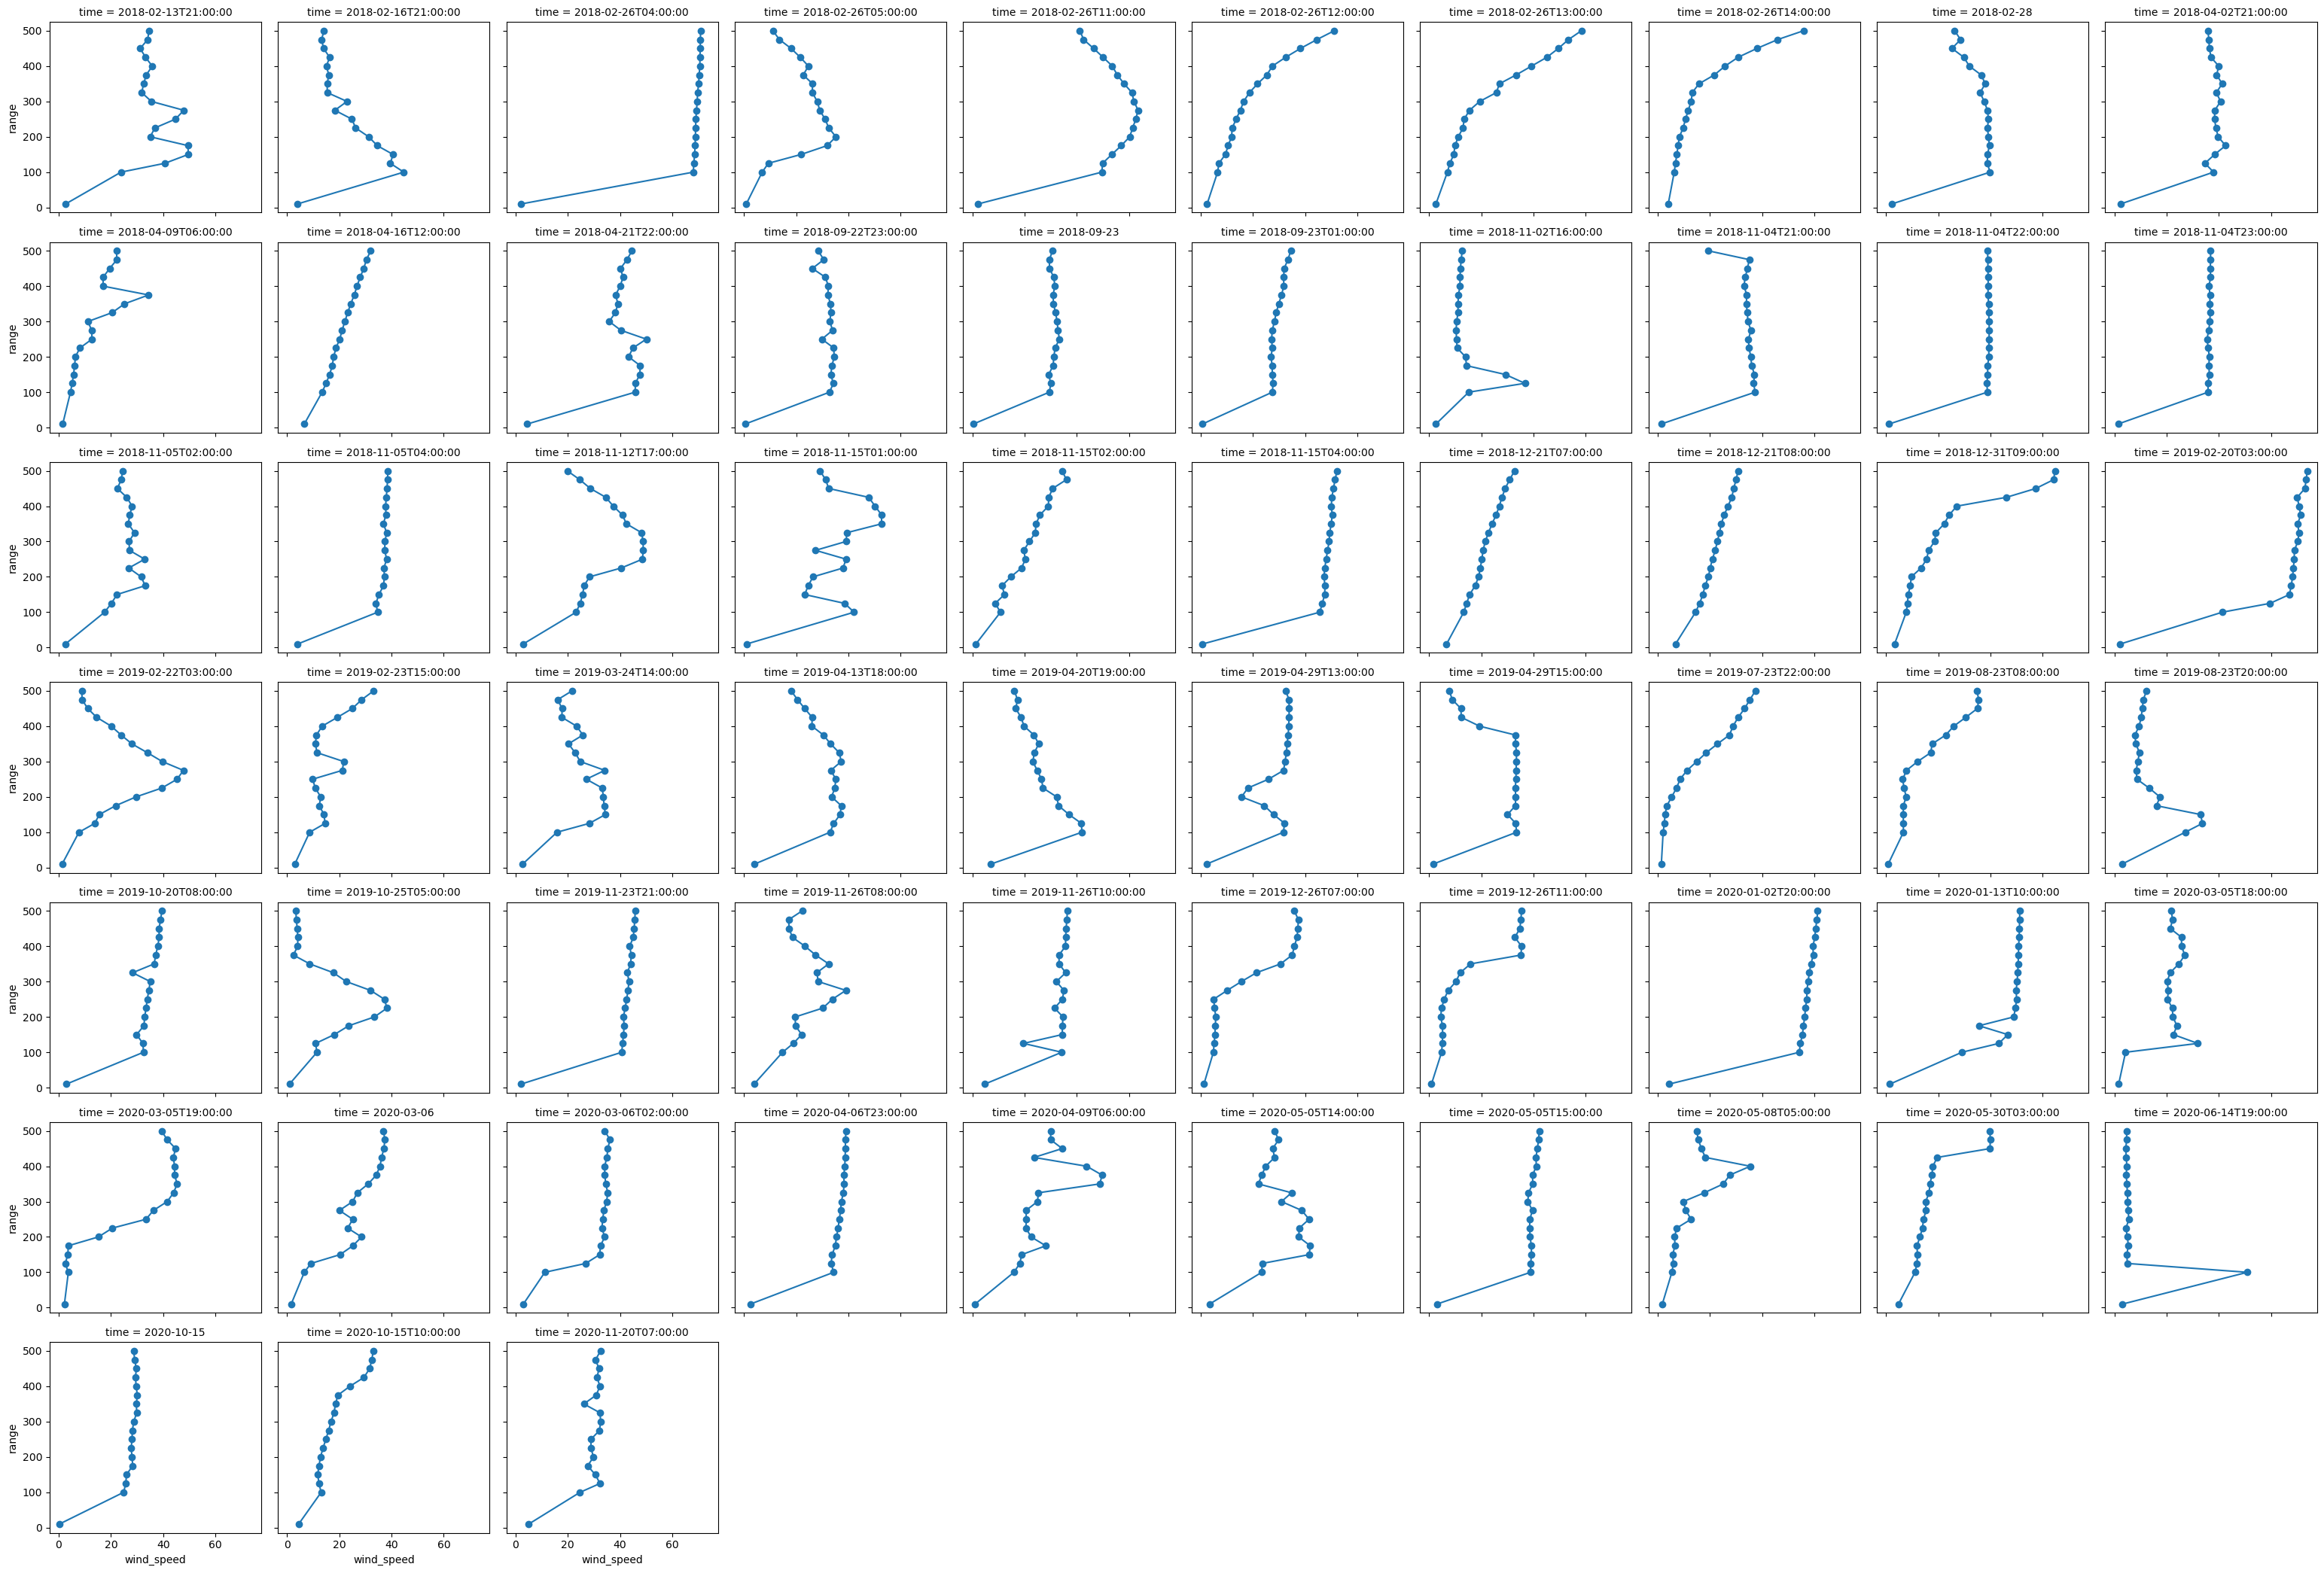

In [12]:
high_wind_instances = (filtered_profiler_data >= 30).compute()

# Find time instances where the condition is met for any station and range
times_with_high_winds = filtered_profiler_data.time.where(high_wind_instances.any(dim=['range']), drop=True)

# Plot the profiles of the stations where wind speed is >= 60 m/s
filtered_profiler_data.sel(time=times_with_high_winds).plot(marker='o',y='range', col='time', col_wrap=10)

- One important note is that, the NYSM-profiler combined wind speed data is averaged over 20 minutes and centered at 0000 UTC. 
- To match the time frame, average the NOW23 data at 55th, 00th, and 5th minutes as well, and center it at 0000 UTC. 

In [10]:
NOW23_z = np.array([10] + list(range(20, 301, 20)) + [400, 500])

dfs = []
for year in range(2018,2021):
    df = pd.read_csv(f'data/NOW23/{station_id}/{year}.csv',index_col=0)
    df.index = pd.to_datetime(df.index)
    dfs.append(df)
combined_df = pd.concat(dfs,axis=0)

NOW23_ds = xr.Dataset(
    data_vars={'wind_speed': (('time_index', 'height'), combined_df.values)},
    coords={'time_index': combined_df.index.values, 'height': NOW23_z}
)

#NOW23_ds = NOW23_ds.sel(time_index=filtered_profiler_data.time.values)
NOW23_ds

<xarray.Dataset> Size: 48MB
Dimensions:     (time_index: 315648, height: 18)
Coordinates:
  * time_index  (time_index) datetime64[ns] 3MB 2018-01-01 ... 2020-12-31T23:...
  * height      (height) int64 144B 10 20 40 60 80 100 ... 260 280 300 400 500
Data variables:
    wind_speed  (time_index, height) float64 45MB 4.61 7.73 8.73 ... 9.18 9.67

In [4]:
common_levels = np.array([10, 100, 125, 150, 175, 200, 225, 250, 275, 300, 400, 500])

print(NOW23_ds.interp(height=common_levels).sel(height=100, time_index=slice('2018-02-01T00','2018-02-01T23')).wind_speed)
print(NOW23_ds.sel(height=100, time_index=slice('2018-02-01T00','2018-02-01T23')).wind_speed)

<xarray.DataArray 'wind_speed' (time_index: 0)> Size: 0B
array([], dtype=float64)
Coordinates:
  * time_index  (time_index) datetime64[ns] 0B 
    height      int64 8B 100
<xarray.DataArray 'wind_speed' (time_index: 0)> Size: 0B
array([], dtype=float64)
Coordinates:
  * time_index  (time_index) datetime64[ns] 0B 
    height      int64 8B 100


In [5]:
common_filtered_profiler_data = filtered_profiler_data.sel(range=common_levels)
common_NOW23_data = NOW23_ds.wind_speed.interp(height=common_levels)

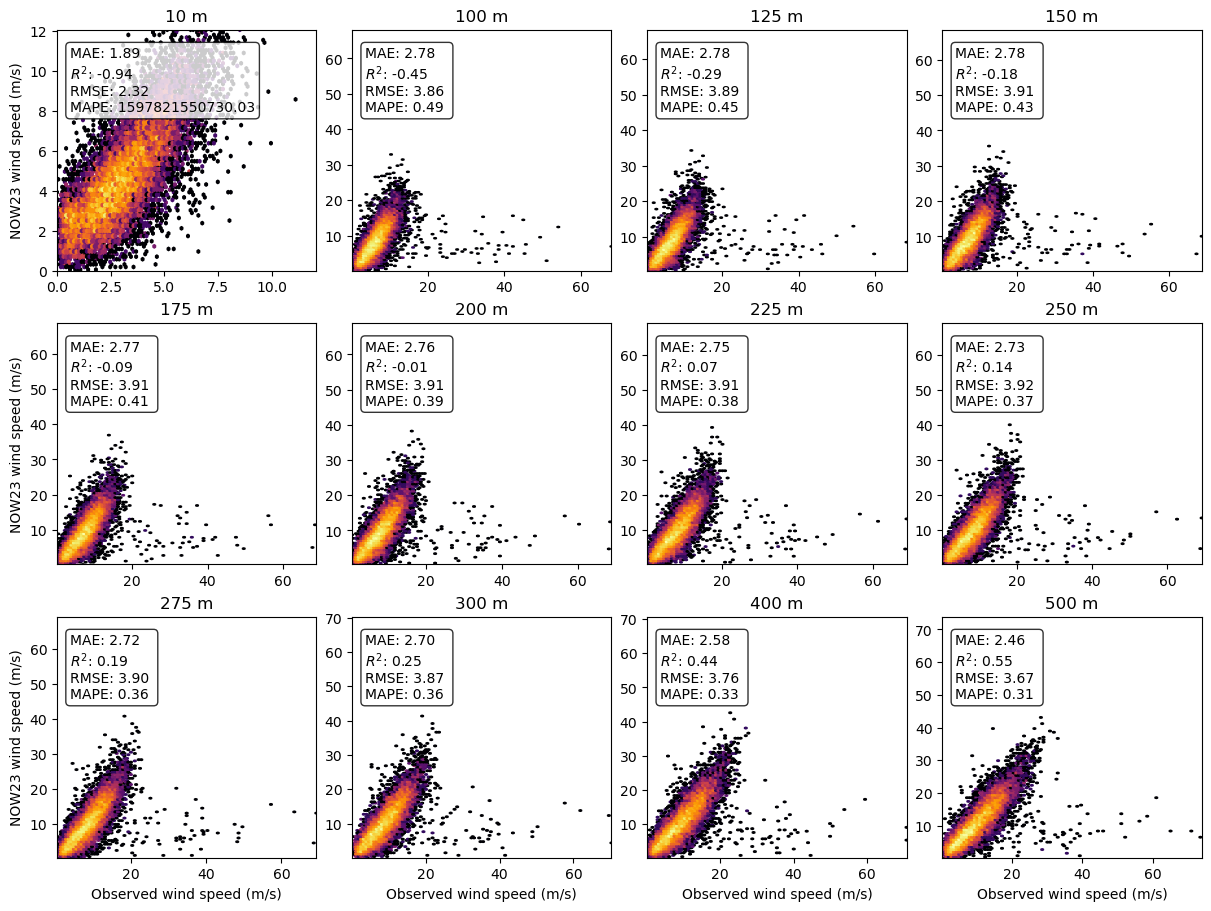

In [6]:
fig = plt.figure(figsize=(12, 9), constrained_layout=True)
gs = fig.add_gridspec(3,4)
for i, level in enumerate(common_levels):
    row = i//4
    col = i%4
    ylabel = 'NOW23 wind speed (m/s)' if col == 0 else ''
    xlabel = 'Observed wind speed (m/s)' if row == 2 else ''
    hexbin_plotter(fig,gs[row,col],common_filtered_profiler_data.sel(range=level),
                common_NOW23_data.sel(height=level),
                f'{level} m',text_arg=True, xlabel=xlabel, ylabel=ylabel)